In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import plotly.offline as py
import plotly.graph_objs as go

import keras_tuner as kt

ModuleNotFoundError: No module named 'plotly'

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [6]:
tf.device('/device:GPU:0')

In [7]:
df = pd.read_csv("../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df['price'] = (df['High']+ df['Low'])/2
df = df.resample('6H').mean()
df = df.dropna()

FileNotFoundError: [Errno 2] No such file or directory: '../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

In [8]:
df.shape

NameError: name 'df' is not defined

In [8]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,price
Timestamp,,,,,,,,
2011-12-31 06:00:00,4.39,4.390000,4.39,4.390000,0.455581,2.000000,4.390000,4.390000
2011-12-31 12:00:00,4.49,4.513333,4.49,4.513333,31.620766,141.106779,4.498804,4.501667
2012-01-01 00:00:00,4.58,4.580000,4.58,4.580000,1.502000,6.879160,4.580000,4.580000
2012-01-01 12:00:00,4.84,4.840000,4.84,4.840000,10.000000,48.400000,4.840000,4.840000
2012-01-01 18:00:00,5.00,5.000000,5.00,5.000000,10.100000,50.500000,5.000000,5.000000


In [9]:
prediction_days = 500
df_train= df['price'][:len(df['price'])-prediction_days].values.reshape(-1,1)
df_test= df['price'][len(df['price'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [10]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [11]:
trainX.shape

(12846, 30)

In [3]:
trainY

NameError: name 'trainY' is not defined

In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
import keras_tuner as kt

def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( trainX.shape[1], trainX.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model
    
tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 3, executions_per_trial =1,directory = "./")

tuner.search(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False)

Trial 3 Complete [00h 01m 50s]
mse: 0.00047095678746700287

Best mse So Far: 0.00047095678746700287
Total elapsed time: 00h 06m 11s


In [15]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
input_unit: 128
n_layers: 2
lstm_0_units: 128
layer_2_neurons: 160
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 64
lstm_2_units: 288
lstm_3_units: 32
Score: 0.00047095678746700287
Trial summary
Hyperparameters:
input_unit: 384
n_layers: 4
lstm_0_units: 384
layer_2_neurons: 512
Dropout_rate: 0.45
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 32
lstm_3_units: 32
Score: 0.07578345388174057
Trial summary
Hyperparameters:
input_unit: 480
n_layers: 2
lstm_0_units: 96
layer_2_neurons: 64
Dropout_rate: 0.25
dense_activation: relu
lstm_1_units: 352
lstm_2_units: 256
lstm_3_units: 96
Score: 0.07578345388174057


In [16]:
best_model = tuner.get_best_models(num_models=1)[0]

In [17]:
history = best_model.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

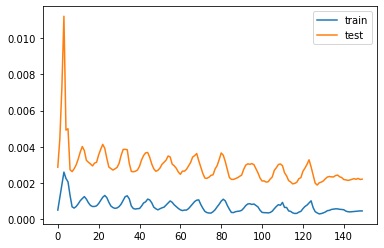

In [18]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
predicted_BTC_price = best_model.predict(testX)

In [20]:
predicted_BTC_price = scaler_test.inverse_transform(predicted_BTC_price.reshape(-1, 1))

In [21]:
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

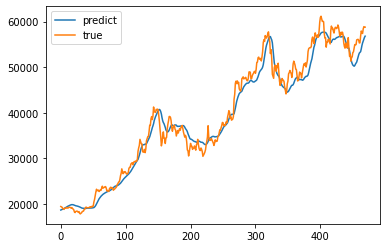

In [22]:
pyplot.plot(predicted_BTC_price, label='predict')
pyplot.plot(true, label='true')
pyplot.legend()
pyplot.show()